This experiment is a simple version of Bell's proposed experiment for testing for Hidden Variables, consisting of measurements in 3 bases. see:
https://www.theory.caltech.edu/~preskill/ph219/Ph-CS-219A-Slides-2020/Ph-CS-219A-Lecture-6-Bell-Inequalities.pptx

In [4]:
#import qiskit tools
import qiskit
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy

from qiskit.visualization import plot_histogram

#import python stuff
import matplotlib.pyplot as plt
import numpy as np
import time

In [5]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (2) and
                                                         not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_quito


In [6]:
sim = Aer.get_backend('aer_simulator')

here we setup the basic circuit consisting which entangles two qubit and measures them according to given angles.

In [56]:
def make_simple_bell_circuit(theta_vec):
    """Return a list of QuantumCircuits for use in a bell experiemnt
    (one for each value of theta in theta_vec)

        Args:
            theta_vec (list): list of values of angles between the bases of Alice and Bob

        Returns:
            List[QuantumCircuit]: basic QuantumCircuits for each value of theta
    """
    chsh_circuits = []

    for theta in theta_vec:
        qc = QuantumCircuit(2,2)
        # create bell state
        qc.h(0)
        qc.cx(0, 1)
        qc.barrier()
        # rotate Alice's qubit around the y axis
        qc.ry(theta, 0)
        qc.measure(range(2),range(2))
        chsh_circuits.append(qc)

    return chsh_circuits

In [53]:
def compute_bell_witness(counts):
    """Computes expectation values for the bell inequality, for each
    angle (theta) between measurement axis.

        Args: counts (list[dict]): dict of counts for each experiment

        Returns:
            List: List with the bell witness
    """

    results = []
    for i in range(0, len(counts)):
        current_count = counts[i]
        no_shots = sum(current_count[y] for y in current_count)

        count_same = current_count['00'] + current_count['11']

        results.append(count_same/no_shots)

    return results

In [57]:
# create basic experiment angles with matching the "3 coins" analogy, ie all angles are 2π/3 apart
number_of_thetas_simple = 4
theta_vec_2 = np.linspace(0,2*np.pi,number_of_thetas_simple)
print(theta_vec_2)
my_bell_circuits_simple = make_simple_bell_circuit(theta_vec_2)

# create expanded experiment angles - many angles
number_of_thetas = 20
theta_vec = np.linspace(0,2*np.pi,number_of_thetas)
print(theta_vec)
my_bell_circuits = make_simple_bell_circuit(theta_vec)

[0.         0.33069396 0.66138793 0.99208189 1.32277585 1.65346982
 1.98416378 2.31485774 2.64555171 2.97624567 3.30693964 3.6376336
 3.96832756 4.29902153 4.62971549 4.96040945 5.29110342 5.62179738
 5.95249134 6.28318531]
[0.         2.0943951  4.1887902  6.28318531]


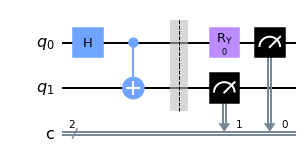

In [58]:
my_bell_circuits_simple[0].draw('mpl')

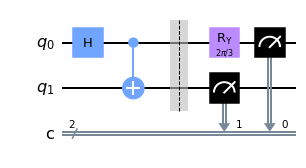

In [59]:
my_bell_circuits_simple[1].draw('mpl')

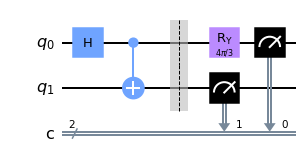

In [61]:
my_bell_circuits_simple[2].draw('mpl')

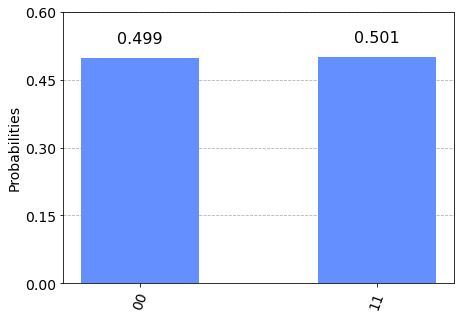

In [51]:
# Execute Simulation for same base measurement
result_same_base = sim.run(my_bell_circuits_simple[0], shots=50000).result()
answer = result_same_base.get_counts()
plot_histogram(answer)

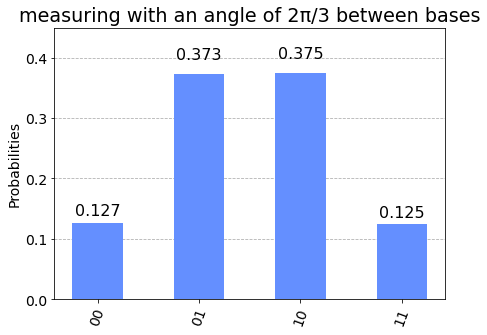

In [52]:
# Execute Simulation and get counts
result_1_2 = sim.run(my_bell_circuits_simple[1], shots=50000).result()
answer = result_1_2.get_counts()

plot_histogram(answer, title='measuring with an angle of 2π/3 between bases')

In [ ]:
# Execute Simulation and get counts
result_ideal = sim.run(my_bell_circuits, shots=8096).result()
answer = result_ideal.get_counts()

# plot_histogram(answer)

In [42]:
# Execute on real device and get counts
startTime = time.time()
transpiled_circuits = transpile(my_bell_circuits, backend)
job_real = backend.run(transpiled_circuits, shots=8096)
job_monitor(job_real)
result_real = job_real.result()
endTime = time.time()

print(endTime - startTime)

Job Status: job has successfully run
5806.136749982834


In [54]:
bell_ideal = compute_bell_witness(result_ideal.get_counts())
bell_real = compute_bell_witness(result_real.get_counts())

AttributeError: module 'matplotlib.pyplot' has no attribute 'ayhline'

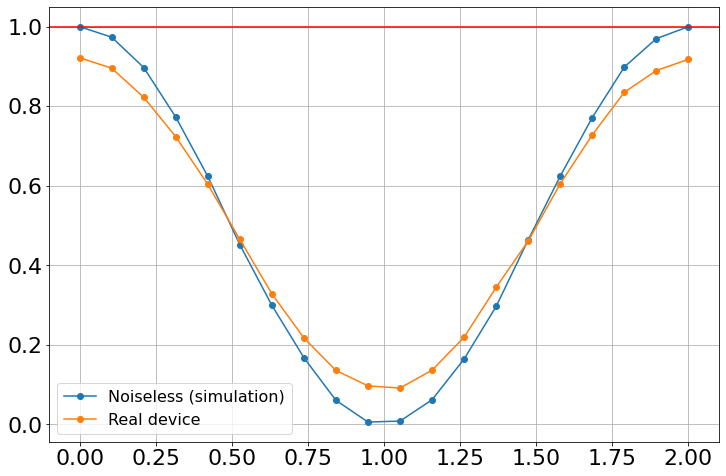

In [62]:
import math

plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 22})
plt.plot(theta_vec/math.pi, bell_ideal, 'o-', label ='Noiseless (simulation)')

plt.plot(theta_vec/math.pi, bell_real, 'o-', label ='Real device')

plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=1, color='r', linestyle='-')
# plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
# plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.ayhline(x=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta (π)')
plt.ylabel('Probability for same outcome for both qubits')